In [ ]:
!pip install tensorflow pandas numpy seaborn matplotlib scikit-learn opencv-python

In [ ]:
from google.colab import drive
import os
import pandas as pd

drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/SMIDS"
categories = ["Abnormal_Sperm", "Non-Sperm", "Normal_Sperm"]

image_paths = []
labels = []

for category in categories:
    category_path = os.path.join(base_path, category)
    for image_name in os.listdir(category_path):
        image_path = os.path.join(category_path, image_name)
        image_paths.append(image_path)
        labels.append(category)

df = pd.DataFrame({"image_path": image_paths, "label": labels})
print(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
                                          image_path           label
0  /content/drive/MyDrive/SMIDS/Abnormal_Sperm/Ab...  Abnormal_Sperm
1  /content/drive/MyDrive/SMIDS/Abnormal_Sperm/Ab...  Abnormal_Sperm
2  /content/drive/MyDrive/SMIDS/Abnormal_Sperm/Ab...  Abnormal_Sperm
3  /content/drive/MyDrive/SMIDS/Abnormal_Sperm/Ab...  Abnormal_Sperm
4  /content/drive/MyDrive/SMIDS/Abnormal_Sperm/Ab...  Abnormal_Sperm


<ipython-input-4-f041e8c00be7>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="label", palette="viridis", ax=ax)


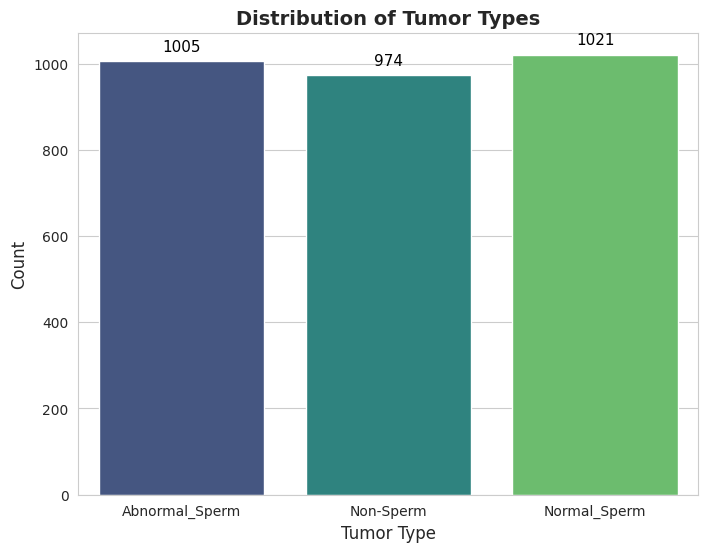

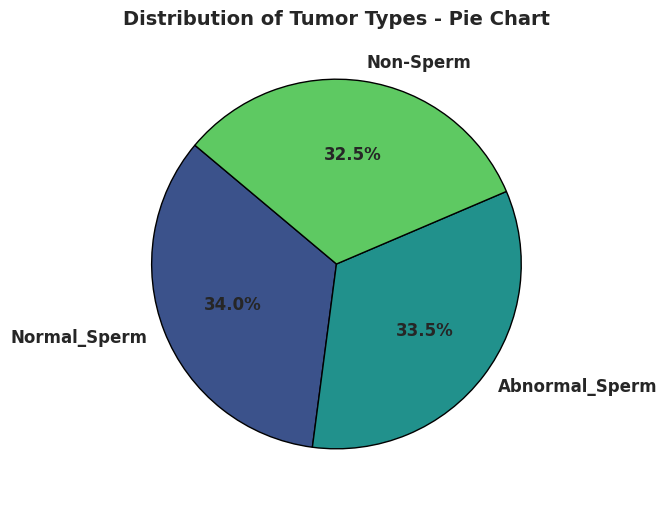

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(data=df, x="label", palette="viridis", ax=ax)

ax.set_title("Distribution of Tumor Types", fontsize=14, fontweight='bold')
ax.set_xlabel("Tumor Type", fontsize=12)
ax.set_ylabel("Count", fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=11, color='black',
                xytext=(0, 5), textcoords='offset points')

plt.show()

label_counts = df["label"].value_counts()

fig, ax = plt.subplots(figsize=(8, 6))
colors = sns.color_palette("viridis", len(label_counts))

ax.pie(label_counts,
       labels=label_counts.index,
       autopct='%1.1f%%',
       startangle=140,
       colors=colors,
       textprops={'fontsize': 12, 'weight': 'bold'},
       wedgeprops={'edgecolor': 'black', 'linewidth': 1})

ax.set_title("Distribution of Tumor Types - Pie Chart", fontsize=14, fontweight='bold')

plt.show()

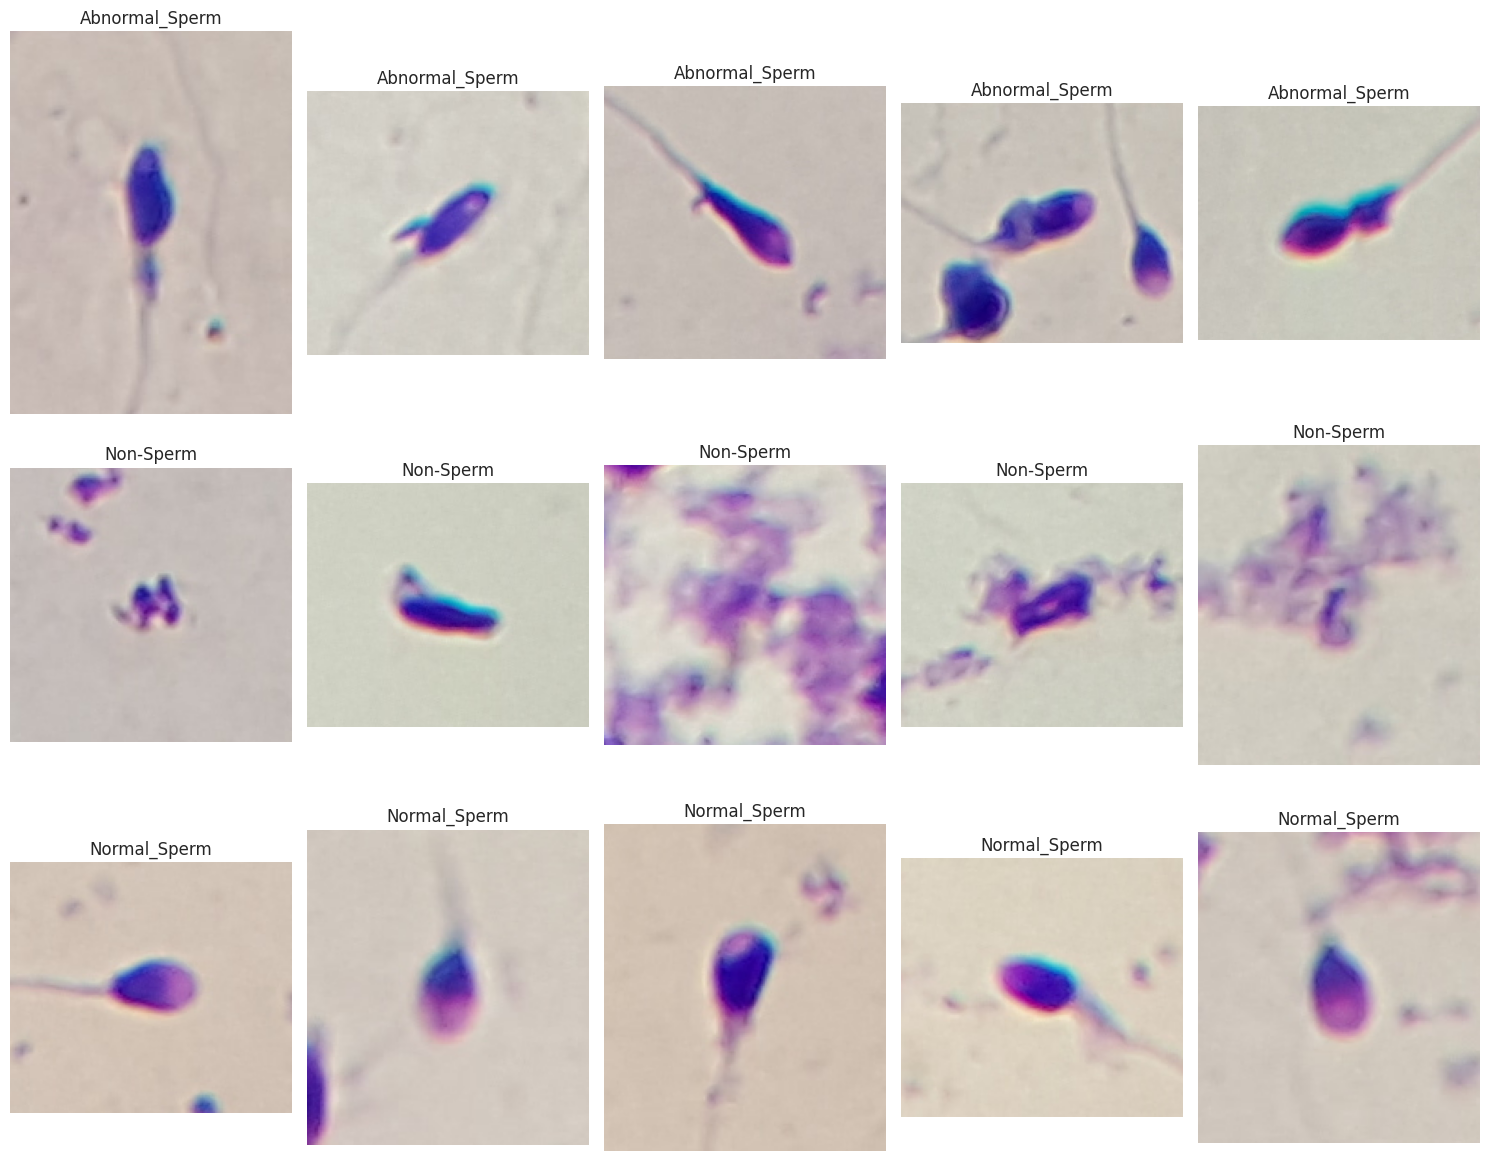

In [ ]:
import cv2
import matplotlib.pyplot as plt

num_images = 5

plt.figure(figsize=(15, 12))

for i, category in enumerate(categories):
    category_images = df[df['label'] == category]['image_path'].iloc[:num_images]

    for j, img_path in enumerate(category_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(len(categories), num_images, i * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(category)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample

label_encoder = LabelEncoder()
df["category_encoded"] = label_encoder.fit_transform(df["label"])

max_count = df["category_encoded"].value_counts().max()
dfs = []
for category in df["category_encoded"].unique():
    class_subset = df[df["category_encoded"] == category]
    class_upsampled = resample(class_subset, replace=True, n_samples=max_count, random_state=42)
    dfs.append(class_upsampled)

df_balanced = pd.concat(dfs).sample(frac=1, random_state=42).reset_index(drop=True)
print(df_balanced["category_encoded"].value_counts())

category_encoded
1    1021
0    1021
2    1021
Name: count, dtype: int64


In [ ]:
df_resampled = df_balanced
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Activation,
    Dropout, BatchNormalization
)
from tensorflow.keras import regularizers

import warnings
warnings.filterwarnings("ignore")

print('check')

check


In [ ]:
import time
import shutil
import pathlib
import itertools
from PIL import Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout,
                                     BatchNormalization, Input, GlobalAveragePooling2D,
                                     GlobalMaxPooling2D, Multiply, Reshape, Add, Concatenate, Layer)
from tensorflow.keras.applications import Xception
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is set for TensorFlow")
    except RuntimeError as e:
        print(e)

Num GPUs Available:  0


In [ ]:
df_resampled = df_balanced
df_resampled['category_encoded'] = df_resampled['category_encoded'].astype(str)

train_df_new, temp_df_new = train_test_split(
    df_resampled, train_size=0.8, shuffle=True, random_state=42, stratify=df_resampled['category_encoded']
)
valid_df_new, test_df_new = train_test_split(
    temp_df_new, test_size=0.5, shuffle=True, random_state=42, stratify=temp_df_new['category_encoded']
)

In [ ]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator(rescale=1./255)
ts_gen = ImageDataGenerator(rescale=1./255)

train_gen_new = tr_gen.flow_from_dataframe(
    train_df_new, x_col='image_path', y_col='category_encoded',
    target_size=img_size, class_mode='sparse', color_mode='rgb',
    shuffle=True, batch_size=batch_size
)

valid_gen_new = ts_gen.flow_from_dataframe(
    valid_df_new, x_col='image_path', y_col='category_encoded',
    target_size=img_size, class_mode='sparse', color_mode='rgb',
    shuffle=True, batch_size=batch_size
)

test_gen_new = ts_gen.flow_from_dataframe(
    test_df_new, x_col='image_path', y_col='category_encoded',
    target_size=img_size, class_mode='sparse', color_mode='rgb',
    shuffle=False, batch_size=batch_size
)

Found 2450 validated image filenames belonging to 3 classes.
Found 306 validated image filenames belonging to 3 classes.
Found 307 validated image filenames belonging to 3 classes.


In [ ]:
class CBAMBlock(Layer):
    def __init__(self, ratio=8, **kwargs):
        super(CBAMBlock, self).__init__(**kwargs)
        self.ratio = ratio

    def build(self, input_shape):
        channel = input_shape[-1]
        self.shared_layer_one = Dense(channel // self.ratio, activation='relu')
        self.shared_layer_two = Dense(channel)
        self.conv_spatial = Conv2D(1, (7, 7), padding='same', activation='sigmoid')
        super(CBAMBlock, self).build(input_shape)

    def call(self, inputs):
        avg_pool = GlobalAveragePooling2D()(inputs)
        avg_pool = Reshape((1, 1, inputs.shape[-1]))(avg_pool)
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)

        max_pool = GlobalMaxPooling2D()(inputs)
        max_pool = Reshape((1, 1, inputs.shape[-1]))(max_pool)
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)

        cbam_feature = Add()([avg_pool, max_pool])
        cbam_feature = Activation('sigmoid')(cbam_feature)
        cbam_feature = Multiply()([inputs, cbam_feature])

        channel_avg = tf.keras.layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(cbam_feature)
        channel_max = tf.keras.layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(cbam_feature)
        spatial_attention = Concatenate(axis=-1)([channel_avg, channel_max])
        spatial_attention = self.conv_spatial(spatial_attention)
        cbam_feature = Multiply()([cbam_feature, spatial_attention])

        return cbam_feature

    def get_config(self):
        config = super(CBAMBlock, self).get_config()
        config.update({'ratio': self.ratio})
        return config

In [ ]:
def create_xception_cbam_model(num_classes, img_shape):
    base_model = Xception(weights='imagenet', include_top=False, input_shape=img_shape)
    base_model.trainable = False

    inputs = Input(shape=img_shape)
    x = base_model(inputs, training=False)
    x = CBAMBlock(ratio=8)(x)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

num_classes = len(train_gen_new.class_indices)
model = create_xception_cbam_model(num_classes, img_shape)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cbam_block (CBAMBlock)          │ (None, 7, 7, 2048)     │     1,050,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,971,278 (87.63 MB)

 Trainable params: 2,105,702 (8.03 MB)

 Non-trainable params: 20,865,576 (79.60 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

epochs = 5
history = model.fit(
    train_gen_new,
    validation_data=valid_gen_new,
    epochs=epochs,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 710s 5s/step - accuracy: 0.7300 - loss: 0.7605 - val_accuracy: 0.8497 - val_loss: 0.9137
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 682s 4s/step - accuracy: 0.8862 - loss: 0.3193 - val_accuracy: 0.8758 - val_loss: 0.6170
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 664s 4s/step - accuracy: 0.9161 - loss: 0.2465 - val_accuracy: 0.8758 - val_loss: 0.3637
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 672s 4s/step - accuracy: 0.9294 - loss: 0.1976 - val_accuracy: 0.8693 - val_loss: 0.3541
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 661s 4s/step - accuracy: 0.9205 - loss: 0.2016 - val_accuracy: 0.8889 - val_loss: 0.3799


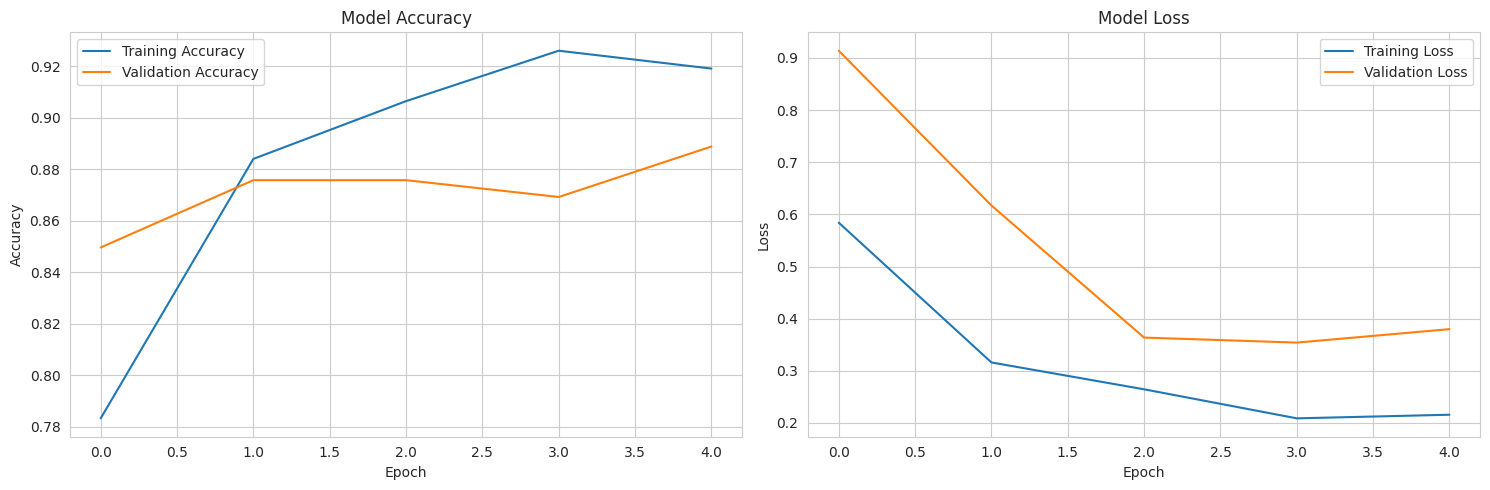

20/20 ━━━━━━━━━━━━━━━━━━━━ 87s 4s/step


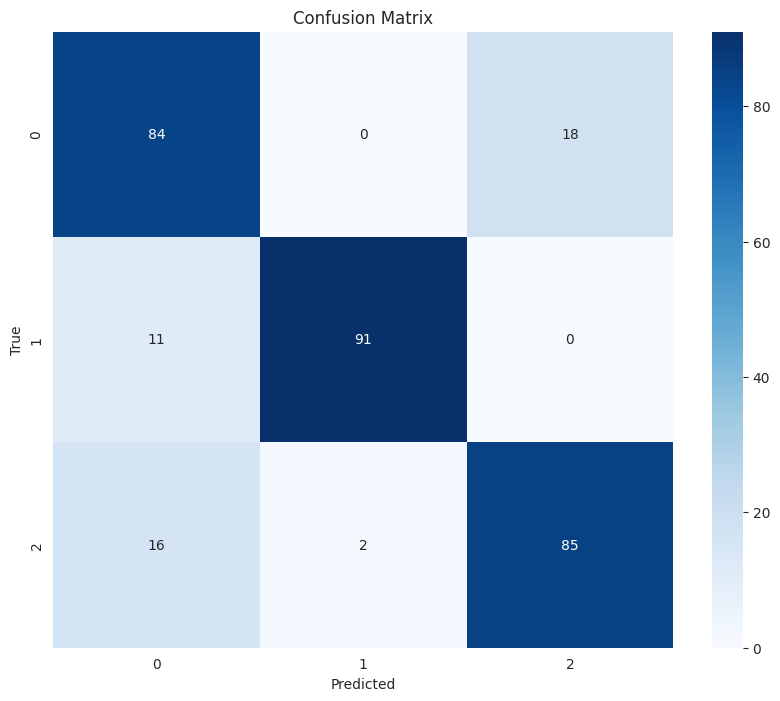


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.82      0.79       102
           1       0.98      0.89      0.93       102
           2       0.83      0.83      0.83       103

    accuracy                           0.85       307
   macro avg       0.85      0.85      0.85       307
weighted avg       0.85      0.85      0.85       307



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

def evaluate_model(model, test_generator):
    test_generator.reset()
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.labels
    class_names = list(test_generator.class_indices.keys())

    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    print("\nClassification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

    return cm, y_pred_classes, y_true

cm, y_pred_classes, y_true = evaluate_model(model, test_gen_new)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.close()

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_gen_new.class_indices.keys()),
            yticklabels=list(test_gen_new.class_indices.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix.png')
plt.close()

report = classification_report(y_true, y_pred_classes,
                                target_names=list(test_gen_new.class_indices.keys()))
with open('classification_report.txt', 'w') as f:
    f.write(report)